### 1. **历史背景与解决的问题**
#### **背景：CNN的长期垄断**
- 在ViT出现前，计算机视觉（CV）任务由卷积神经网络（CNN）主导（如ResNet、YOLO系列），其核心是通过局部卷积操作提取空间特征，依赖归纳偏置（局部性、平移不变性）简化学习过程。
- Transformer架构自2017年提出后在自然语言处理（NLP）领域（如BERT、GPT）取得突破，但其在CV的应用受限于图像的非序列特性——直接处理像素会导致序列过长（如224×224图像有50,176个像素），计算复杂度高达O(N²)。

#### **核心问题：全局依赖建模的瓶颈**
- CNN的局部感受野难以建模图像中的**长距离依赖关系**（例如跨区域物体关联），需堆叠多层扩大感受野，效率较低。
- 早期将Transformer引入CV的尝试（如DETR）需依赖CNN backbone提取特征，未实现真正的"纯Transformer"架构。

#### **ViT的提出**
- 2020年Google Research团队发表论文《An Image is Worth 16x16 Words》，首次提出**纯Transformer的视觉模型ViT**，并在ImageNet分类任务上超越CNN，引发CV范式变革。

---

### 2. **模型的创新性与影响**
#### **核心创新**
- **图像分块序列化**  
  将输入图像分割为固定大小的块（如16×16像素），每个块展平为向量，视为"视觉单词"。例如224×224图像被转化为196个块序列，大幅降低序列长度。
- **位置编码保留空间信息**  
  引入可学习的位置编码（Positional Encoding），附加到块嵌入向量中，使模型感知空间结构。
- **全局自注意力机制**  
  通过多头自注意力（MHSA）层建模所有块之间的关系，实现**全局上下文感知**。例如在分类任务中，模型可同时关联图像角落与中心的关键特征。

#### **突破性影响**
- **打破CNN垄断，确立新范式**  
  ViT证明在大规模数据（如JFT-300M）预训练下，纯Transformer在ImageNet准确率超越ResNet，验证了"注意力机制足以替代卷积"。
- **推动多模态融合**  
  ViT成为视觉-语言多模态模型（如CLIP）的基础，实现跨模态对齐（图像-文本），支撑零样本检索、生成式AI等应用。
- **激发高效架构创新**  
  - **层级设计**：Swin Transformer引入局部窗口注意力，降低计算复杂度  
  - **过拟合优化**：DropKey通过随机丢弃Key缓解小数据过拟合  
  - **模型压缩**：ViT-Slim联合优化分块、注意力头等维度

#### **局限与后续改进**
| **挑战**               | **解决方案**                          | **代表工作**      |
|------------------------|--------------------------------------|------------------|
| 数据需求高             | 千亿级数据集预训练                   | Google DeepMind  |
| 计算复杂度高（O(N²)）  | 局部注意力、渐进式Token缩减          | Swin, As-ViT     |
| 位置编码灵活性不足     | 相对位置编码、可学习动态编码         | OCR-ViT          |

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
max_epochs = 300
print("Use device: ", DEVICE)

Use device:  cuda


In [ ]:
from hdd.data_util.auto_augmentation import CIFAR10Policy

# 训练超参数和数据增强来自 https://github.com/omihub777/ViT-CIFAR
CIFAR_10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_10_STD = [0.2470, 0.2435, 0.2616]
BATCH_SIZE = 128

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_10_MEAN, CIFAR_10_STD),
    ]
)

val_dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root=DATA_ROOT, train=False, download=True, transform=val_transform
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

train_transform = transforms.Compose(
    [
        transforms.RandomCrop(size=32, padding=4),
        transforms.RandomHorizontalFlip(),
        CIFAR10Policy(),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_10_MEAN, CIFAR_10_STD),
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root=DATA_ROOT, train=True, download=True, transform=train_transform
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from hdd.train.warmup_scheduler import GradualWarmupScheduler
from hdd.models.transformer.vit import ViT
from hdd.train.classification_utils import naive_train_classification_model
from hdd.models.nn_utils import count_trainable_parameter


net = ViT(
    num_classes=10,
    image_size=32,
    patch_size=4,
    embed_dim=384,
    n_heads=12,
    diff_dim=384,
    dropout=0.0,
    num_layers=7,
).to(DEVICE)
print(f"#Parameter: {count_trainable_parameter(net)}")
criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(
    net.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-5
)

base_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, max_epochs, eta_min=1e-5
)
scheduler = GradualWarmupScheduler(
    optimizer,
    multiplier=1.0,
    total_epoch=10,
    after_scheduler=base_scheduler,
)
patch_4 = naive_train_classification_model(
    net,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    verbose=True,
)

#Parameter: 6269578
Epoch: 1/300 Train Loss: 2.9985 Accuracy: 0.1243 Time: 9.37731  | Val Loss: 3.0068 Accuracy: 0.1397
Epoch: 2/300 Train Loss: 2.1759 Accuracy: 0.2201 Time: 9.53837  | Val Loss: 1.9227 Accuracy: 0.3281
Epoch: 3/300 Train Loss: 2.0108 Accuracy: 0.2938 Time: 9.40795  | Val Loss: 1.8300 Accuracy: 0.3818
Epoch: 4/300 Train Loss: 1.8642 Accuracy: 0.3686 Time: 9.49997  | Val Loss: 1.6578 Accuracy: 0.4663
Epoch: 5/300 Train Loss: 1.7578 Accuracy: 0.4166 Time: 9.47084  | Val Loss: 1.5611 Accuracy: 0.5123
Epoch: 6/300 Train Loss: 1.6875 Accuracy: 0.4530 Time: 9.42273  | Val Loss: 1.4865 Accuracy: 0.5441
Epoch: 7/300 Train Loss: 1.6463 Accuracy: 0.4720 Time: 9.40787  | Val Loss: 1.4703 Accuracy: 0.5551
Epoch: 8/300 Train Loss: 1.6226 Accuracy: 0.4857 Time: 9.46501  | Val Loss: 1.4259 Accuracy: 0.5787
Epoch: 9/300 Train Loss: 1.6080 Accuracy: 0.4932 Time: 9.36587  | Val Loss: 1.4152 Accuracy: 0.5805
Epoch: 10/300 Train Loss: 1.6007 Accuracy: 0.4959 Time: 9.40341  | Val Loss: 1.3

In [10]:
net = ViT(
    num_classes=10,
    image_size=32,
    patch_size=8,
    embed_dim=384,
    n_heads=12,
    diff_dim=384,
    dropout=0.0,
    num_layers=7,
).to(DEVICE)
print(f"#Parameter: {count_trainable_parameter(net)}")
criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))

base_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, max_epochs, eta_min=1e-5
)
scheduler = GradualWarmupScheduler(
    optimizer,
    multiplier=1.0,
    total_epoch=10,
    after_scheduler=base_scheduler,
)
patch_8 = naive_train_classification_model(
    net,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    verbose=True,
)

#Parameter: 6306442
Epoch: 1/300 Train Loss: 3.1279 Accuracy: 0.0942 Time: 3.56637  | Val Loss: 3.0449 Accuracy: 0.0869
Epoch: 2/300 Train Loss: 2.2410 Accuracy: 0.1922 Time: 3.61331  | Val Loss: 2.0249 Accuracy: 0.2864
Epoch: 3/300 Train Loss: 2.1134 Accuracy: 0.2432 Time: 3.59311  | Val Loss: 1.9284 Accuracy: 0.3316
Epoch: 4/300 Train Loss: 2.0621 Accuracy: 0.2654 Time: 3.71425  | Val Loss: 1.9085 Accuracy: 0.3322
Epoch: 5/300 Train Loss: 2.0156 Accuracy: 0.2886 Time: 3.60182  | Val Loss: 1.8586 Accuracy: 0.3677
Epoch: 6/300 Train Loss: 1.9792 Accuracy: 0.3032 Time: 3.43660  | Val Loss: 1.8060 Accuracy: 0.3868
Epoch: 7/300 Train Loss: 1.9354 Accuracy: 0.3302 Time: 3.38643  | Val Loss: 1.7572 Accuracy: 0.4231
Epoch: 8/300 Train Loss: 1.8896 Accuracy: 0.3540 Time: 3.45931  | Val Loss: 1.7491 Accuracy: 0.4304
Epoch: 9/300 Train Loss: 1.8585 Accuracy: 0.3696 Time: 3.51902  | Val Loss: 1.7137 Accuracy: 0.4481
Epoch: 10/300 Train Loss: 1.8269 Accuracy: 0.3854 Time: 3.27143  | Val Loss: 1.6

In [11]:
net = ViT(
    num_classes=10,
    image_size=32,
    patch_size=16,
    embed_dim=384,
    n_heads=12,
    diff_dim=384,
    dropout=0.0,
    num_layers=7,
).to(DEVICE)
print(f"#Parameter: {count_trainable_parameter(net)}")
criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))

base_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, max_epochs, eta_min=1e-5
)
scheduler = GradualWarmupScheduler(
    optimizer,
    multiplier=1.0,
    total_epoch=10,
    after_scheduler=base_scheduler,
)
patch_16 = naive_train_classification_model(
    net,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    verbose=True,
)

#Parameter: 6523018
Epoch: 1/300 Train Loss: 3.2106 Accuracy: 0.0983 Time: 2.64844  | Val Loss: 3.3281 Accuracy: 0.0871
Epoch: 2/300 Train Loss: 2.2740 Accuracy: 0.1886 Time: 2.91198  | Val Loss: 2.0548 Accuracy: 0.2869
Epoch: 3/300 Train Loss: 2.1398 Accuracy: 0.2348 Time: 2.83131  | Val Loss: 1.9721 Accuracy: 0.3212
Epoch: 4/300 Train Loss: 2.0879 Accuracy: 0.2614 Time: 2.46124  | Val Loss: 1.9293 Accuracy: 0.3403
Epoch: 5/300 Train Loss: 2.0483 Accuracy: 0.2803 Time: 3.11058  | Val Loss: 1.9001 Accuracy: 0.3461
Epoch: 6/300 Train Loss: 2.0122 Accuracy: 0.2967 Time: 3.01912  | Val Loss: 1.8865 Accuracy: 0.3595
Epoch: 7/300 Train Loss: 1.9824 Accuracy: 0.3120 Time: 3.13927  | Val Loss: 1.8378 Accuracy: 0.3820
Epoch: 8/300 Train Loss: 1.9559 Accuracy: 0.3215 Time: 2.98820  | Val Loss: 1.8384 Accuracy: 0.3879
Epoch: 9/300 Train Loss: 1.9253 Accuracy: 0.3383 Time: 2.93976  | Val Loss: 1.7970 Accuracy: 0.4021
Epoch: 10/300 Train Loss: 1.9014 Accuracy: 0.3520 Time: 2.60348  | Val Loss: 1.8

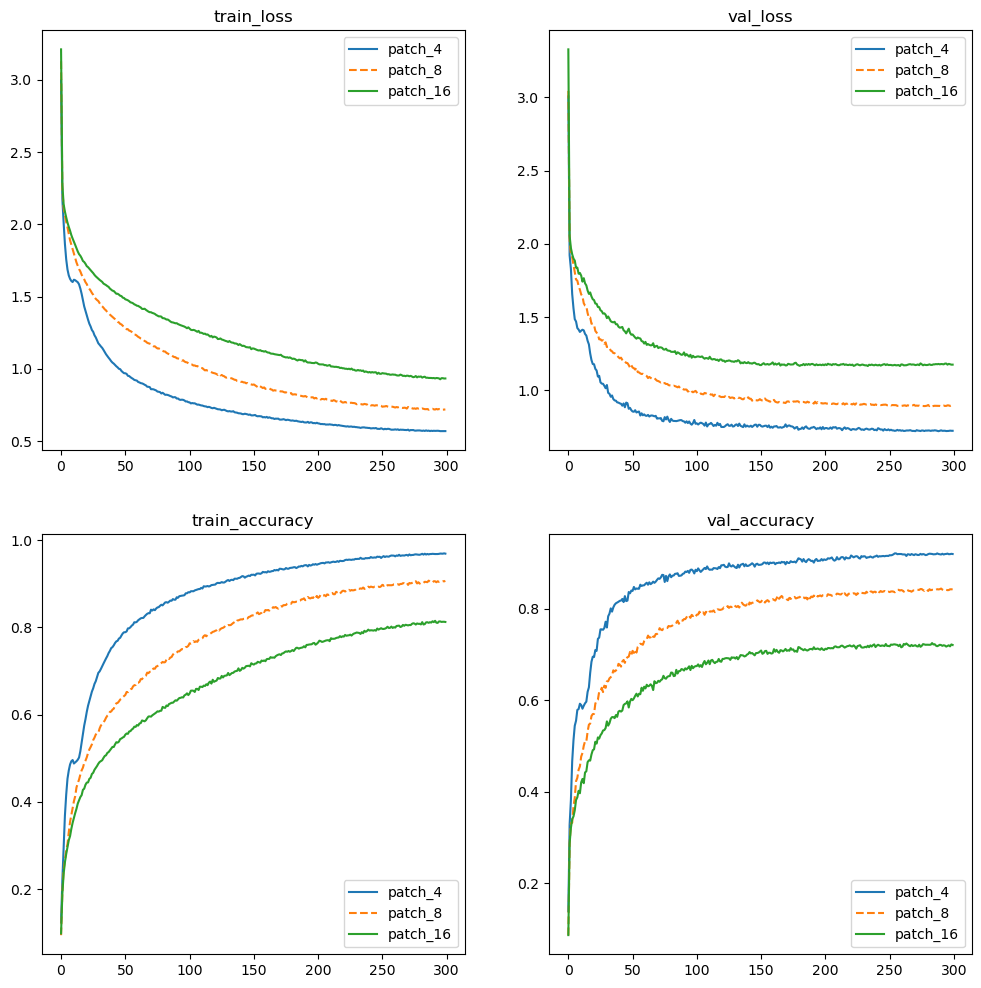

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = patch_8.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(patch_4[field], label="patch_4")
    plt.plot(patch_8[field], label="patch_8", linestyle="--")
    plt.plot(patch_16[field], label="patch_16", linestyle="-")
    plt.legend()
    plt.title(field)